# Chapter 7
## Detection Using Neural Networks

In [1]:
import os, sys
import numpy as np
from math import floor
import pickle
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
from scipy import signal
import multiprocessing as mp


from sklearn import model_selection,preprocessing
# os.environ['THEANO_FLAGS'] = "device=cuda,force_device=True,floatX=float32"
# os.environ["KERAS_BACKEND"] = "theano"
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1,l2, l1_l2
from tensorflow.keras.utils import plot_model, to_categorical



# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from yolo_data_aug import YOLODataAug
from yolo_detector import YOLODetector
from nn_detector import NeuralNetworkDetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
site = 'marion'
database = Database(dataset_loc, database_loc, site)


linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

# use gpu
# print('GPUs:',K.tensorflow_backend._get_available_gpus())
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

##  **6.2 Classifier Design**

### Dataset

**Generate Dataset**

In [2]:
# transforms, transforms_params = ['slice', 'scale'], [[1.5,9.5],[0,1]]
trans, trans_params = None, None
nn = NeuralNetworkDetector(dataset_loc, database_loc, site, trans, trans_params)

transforms, transforms_params = ['slice',trans,'scale'], [[1.5,9.5],trans_params,[0,1]]
cut_params = [1,0.2,8,1.5,2]
# database.create_cuts_db_mp(transforms, transforms_params,cut_params, verbose=True, noise=True, train=True, test=False, n=None)

**Show dataset statistics**

In [4]:
_ = database.stats(transforms, transforms_params,cut_params, noise=True, test=False)

/srv/home/knnoth001/wdml/data/databases/awdEvents1/marion/marion_h5/['slice', 'detrend', 'scale']_[[1.5, 9.5], 'constant', [0, 1]]_[1, 0.2, 8, 1.5, 2]_True/train
samples:  11148


100%|██████████| 11148/11148 [00:08<00:00, 1274.74it/s]



Database statistics               
min                   0           
max                   1           
mean                  0.615       
std                   0.101       
noise                 2831[25.39%]
whistler              8317[74.61%]
total                 11148       



**Load dataset**

In [3]:
X , Y = database.load_cuts_db_mp(transforms, transforms_params,cut_params, noise=True, verbose=True, test=False, shuffle=True, random_state=42)

/srv/home/knnoth001/wdml/data/databases/awdEvents1/marion/marion_h5/['slice', None, 'scale']_[[1.5, 9.5], None, [0, 1]]_[1, 0.2, 8, 1.5, 2]_True/train
samples:  11148


100%|██████████| 11148/11148 [00:08<00:00, 1278.66it/s]


**Show few examples**

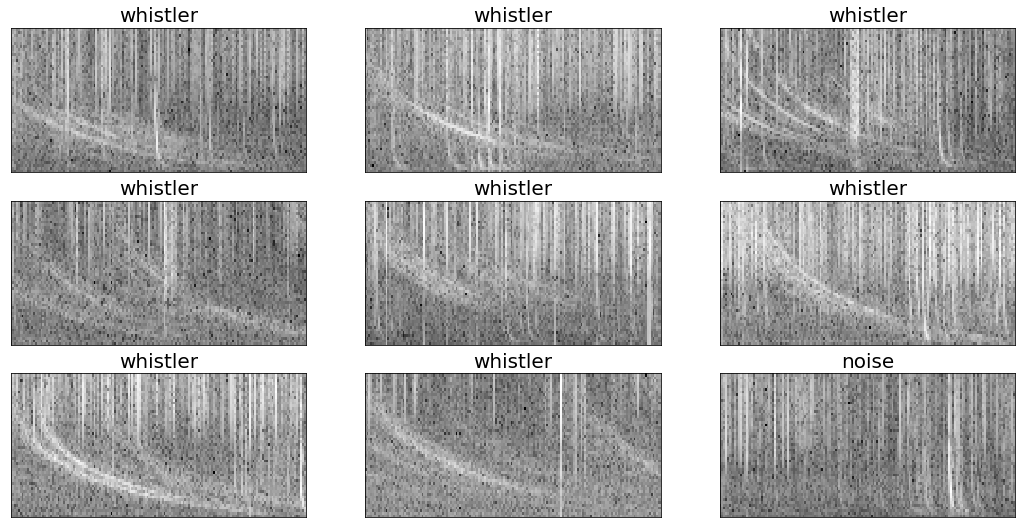

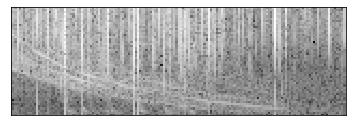

In [4]:
x_size = 3
y_size = 3
scale = 3
plt.figure(figsize=(y_size*2*scale, x_size*scale))
for ix in range(x_size*y_size):
    ax = plt.subplot(x_size, y_size, ix+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(len(Y))
    plt.pcolormesh(X[index], cmap='gray')
    ax.set_title('whistler' if Y[index]==1 else 'noise', fontsize=font[1])
plt.show()
plt.figure(figsize=(2*X[179].shape[1]/X[179].shape[0],2))
plt.pcolormesh(X[0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

**Reshape data and label and rescale it**

In [5]:
freq_len, time_len = X[0].shape
data = X.reshape(len(X),freq_len*time_len)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
data = data.reshape((len(data),1,freq_len,time_len))
evt = to_categorical(Y)
print(X.shape, Y.shape)
print(data.shape,evt.shape)
print(Y)

(11148, 52, 156) (11148,)
(11148, 1, 52, 156) (11148, 2)
[ True  True False ...  True False  True]


**Define Model**

In [6]:
def create_model(lrate=0.001, epochs=150, dropout=True):
    model = Sequential()
    # model.add(Input(data[0].shape))
    model.add(Conv2D(2,(23, 23), input_shape=(1,freq_len, time_len),
                        padding='same', activation='relu',data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
    if dropout: model.add(Dropout(rate=0.5));
    model.add(Conv2D(4, (7,7), activation='relu', padding='same',data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
    if dropout: model.add(Dropout(rate=0.4));
    model.add(Conv2D(8, (5,5), activation='relu', padding='same',data_format='channels_first'))

    # model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
    # model.add(Dropout(rate=0.3))
    # model.add(Conv2D(16, (7,7), activation='relu', padding='same',data_format='channels_first'))
    # model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
    # model.add(Dropout(rate=0.2))

    model.add(Flatten())
    if dropout: model.add(Dropout(rate=0.3));
    model.add(Dense(128, activation='relu'))
    if dropout: model.add(Dropout(rate=0.3));
    model.add(Dense(2, activation='softmax'))

    #compile model
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    adam = Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model
model = create_model(lrate=0.001, epochs=150)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 52, 156)        1060      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 26, 78)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 26, 78)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 26, 78)         396       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 13, 39)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 13, 39)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 13, 39)         8

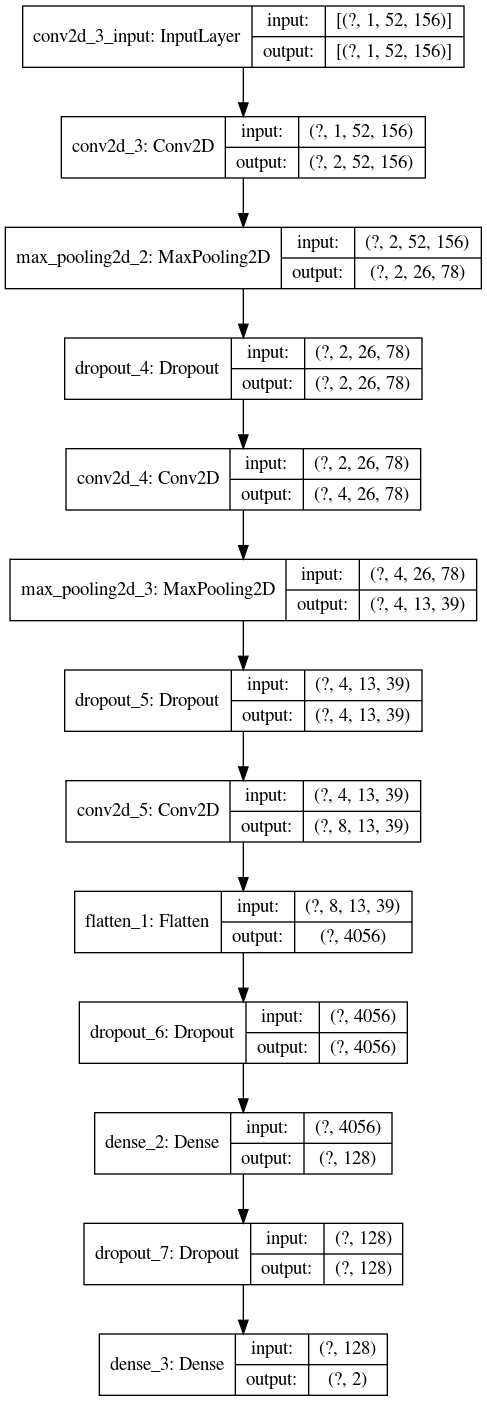

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False)

**Reducing Overfitting with Dropout Layers**

In [48]:
histories = []
scores = []
dropout=False
from sklearn.model_selection import StratifiedShuffleSplit
ix, n_splits = 0, 1
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.33, random_state=0)
for train_index, test_index in sss.split(data, evt):
    print('Fold %d/%d'%(ix+1, n_splits))
    data_train, data_test = data[train_index], data[test_index]
    evt_train, evt_test = evt[train_index], evt[test_index]
    # create and train model
    model = create_model(lrate=0.001, epochs=150, dropout=dropout)
    history = model.fit(data_train, evt_train, validation_data=(data_test, evt_test), epochs=150, batch_size=250, shuffle=True, verbose=1)
    histories.append(history.history)
    predictions = model.evaluate(data_test, evt_test, verbose=0)
    scores.append(predictions)
    ix += 1
scores = np.array(scores)

Fold 1/1
Train on 7469 samples, validate on 3679 samples
Epoch 1/150
7469/7469 [==============================] - 3s 341us/sample - loss: 0.4986 - accuracy: 0.7543 - val_loss: 0.2878 - val_accuracy: 0.9201
Epoch 2/150
7469/7469 [==============================] - 2s 264us/sample - loss: 0.2102 - accuracy: 0.9207 - val_loss: 0.1703 - val_accuracy: 0.9337
Epoch 3/150
7469/7469 [==============================] - 2s 263us/sample - loss: 0.1757 - accuracy: 0.9345 - val_loss: 0.1555 - val_accuracy: 0.9407
Epoch 4/150
7469/7469 [==============================] - 2s 263us/sample - loss: 0.1625 - accuracy: 0.9396 - val_loss: 0.1511 - val_accuracy: 0.9456
Epoch 5/150
7469/7469 [==============================] - 2s 265us/sample - loss: 0.1534 - accuracy: 0.9426 - val_loss: 0.1401 - val_accuracy: 0.9451
Epoch 6/150
7469/7469 [==============================] - 2s 264us/sample - loss: 0.1481 - accuracy: 0.9462 - val_loss: 0.1425 - val_accuracy: 0.9484
Epoch 7/150
7469/7469 [==========================

In [49]:
name = 'cnn-3-ndropout'if not dropout else 'cnn-3-dropout'
# save scaler
nn.save_scaler(scaler, name=name)
# save history
nn.save_history(history, name=name)
# save model
nn.save_model(model, name=name)

Saving scaler .... Done.
Saving history .... Done.
Saving model .... Done.


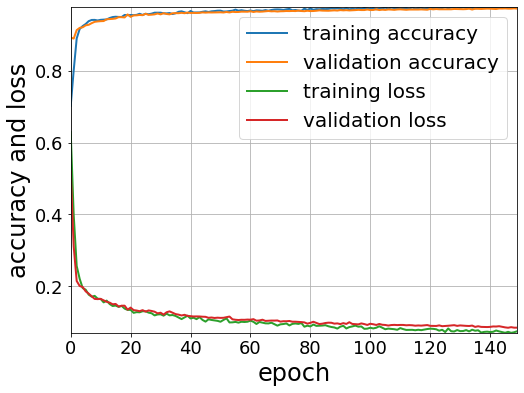

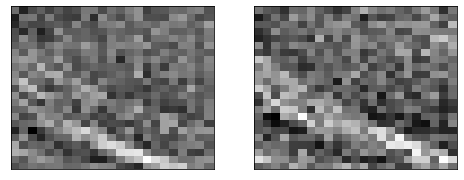

In [51]:
dropout = True
name = 'cnn-3-ndropout'if not dropout else 'cnn-3-dropout'
history = nn.load_history(name=name)
scaler = nn.load_scaler(name=name)
model = nn.load_model(name=name)
# summarize history for accuracy
nn.show_history(history, figsize=(8,6),font=font)
nn.visualization(model, figsize=(8,3), conv_layer_number=0)

**Classifier results**

In [7]:
histories = []
scores = []
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.callbacks import EarlyStopping

ix, n_splits = 0, 1
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.33, random_state=0)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
for train_index, test_index in sss.split(data, evt):
    print('Fold %d/%d'%(ix+1, n_splits))
    data_train, data_test = data[train_index], data[test_index]
    evt_train, evt_test = evt[train_index], evt[test_index]
    # create and train model
    model = create_model(lrate=0.001, epochs=150, dropout=True)
    history = model.fit(data_train, evt_train, validation_data=(data_test, evt_test), epochs=100, batch_size=250, shuffle=True, verbose=1)#, callbacks=[es])
    histories.append(history.history)
    predictions = model.evaluate(data_test, evt_test, verbose=0)
    scores.append(predictions)
    ix += 1
scores = np.array(scores)

Fold 1/1
Train on 7469 samples, validate on 3679 samples
Epoch 1/100
7469/7469 [==============================] - 5s 658us/sample - loss: 0.6442 - accuracy: 0.7135 - val_loss: 0.5716 - val_accuracy: 0.7469
Epoch 2/100
7469/7469 [==============================] - 2s 262us/sample - loss: 0.4736 - accuracy: 0.7712 - val_loss: 0.4426 - val_accuracy: 0.8239
Epoch 3/100
7469/7469 [==============================] - 2s 265us/sample - loss: 0.3704 - accuracy: 0.8235 - val_loss: 0.3109 - val_accuracy: 0.8861
Epoch 4/100
7469/7469 [==============================] - 2s 264us/sample - loss: 0.3059 - accuracy: 0.8642 - val_loss: 0.2827 - val_accuracy: 0.9000
Epoch 5/100
7469/7469 [==============================] - 2s 263us/sample - loss: 0.2808 - accuracy: 0.8787 - val_loss: 0.2562 - val_accuracy: 0.9157
Epoch 6/100
7469/7469 [==============================] - 2s 264us/sample - loss: 0.2532 - accuracy: 0.8917 - val_loss: 0.2439 - val_accuracy: 0.9214
Epoch 7/100
7469/7469 [==========================

In [8]:
name = 'cnn-3conv-2dense-4dropout-100epochs'
# save scaler
nn.save_scaler(scaler, name=name)
# save history
nn.save_history(history, name=name)
# save model
nn.save_model(model, name=name)
nn.save_fold_training_results(histories, scores, name)

Saving scaler .... Done.
Saving history .... Done.
Saving model .... Done.
Saving fold training results .... Done.


In [7]:
name = 'cnn-3conv-2dense-4dropout-100epochs'
trans, trans_params = 'detrend', 'linear'
nn = NeuralNetworkDetector(dataset_loc, database_loc, site, trans, trans_params)
h, s, nbr_fold, nbr_epochs = nn.load_fold_training_results(name)
# nn.show_histories(h, figsize=(20,8),font=font)
print(s)
print('Loss: %.3f+-%.3f'%(s[:,0].mean(),s[:,0].std()))
print('Accuracy: %.3f+-%.3f'%(s[:,1].mean(),s[:,1].std()))

[[0.09574275 0.96955693]]
Loss: 0.096+-0.000
Accuracy: 0.970+-0.000


In [5]:
model = nn.load_model(name=name)
scaler = nn.load_scaler(name=name)
kernels = []
for i in range(3):
    filters, biases = nn.get_conv_layers(model)[i].get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters = (filters-f_min)/(f_max-f_min)
    n_filters, ix = filters.shape[-1], 1
    for i in range(n_filters):
        # get the filters
        f = filters[:,:,:,i]
        kernels.append(f[:,:,0])
        

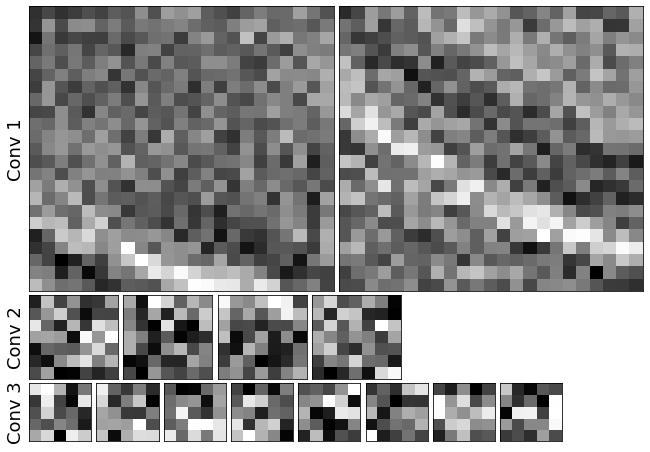

In [6]:
fig = plt.figure(figsize=(11,8))
grid = plt.GridSpec(35, 46, wspace=0.6, hspace=0.6)
ix = 0
for i in range(2):
    ax = fig.add_subplot(grid[:23, i*23:(i+1)*23])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.pcolormesh(kernels[ix],cmap='gray')
    if i==0: ax.set_ylabel('Conv 1', fontsize=font[3]);
    ix += 1
for i in range(4):
    ax = fig.add_subplot(grid[23:23+7, i*7:(i+1)*7])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.pcolormesh(kernels[ix],cmap='gray')
    if i==0: ax.set_ylabel('Conv 2', fontsize=font[3]);
    ix += 1
for i in range(8):
    ax = fig.add_subplot(grid[23+7:23+7+5, i*5:(i+1)*5])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.pcolormesh(kernels[ix],cmap='gray')
    if i==0: ax.set_ylabel('Conv 3', fontsize=font[3]);
    ix += 1
plt.show()

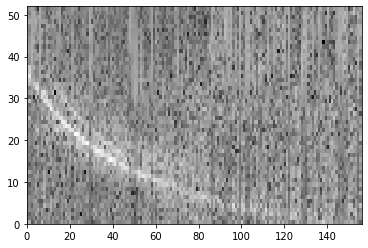

In [24]:
def reshape(x):
    f,t = x.shape
    x = x.reshape(1,f*t)
    x = scaler.transform(x)
    x = x.reshape(1,1,f,t)
    return x
w, n = np.argwhere(Y==True)[:,0], np.argwhere(Y==False)[:,0]
data_index = w[100]
# data_index = n[150]
data_sample = X[data_index]
plt.pcolormesh(data_sample,cmap='gray')

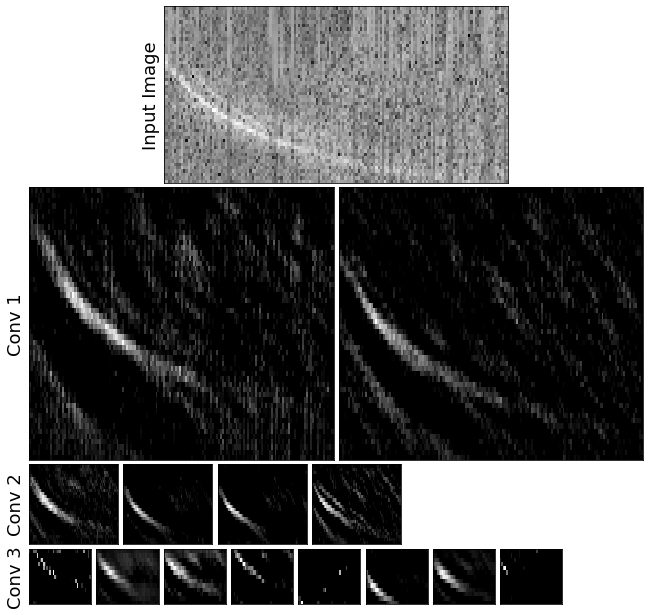

In [25]:
c, c1, c2, c3 = 15,23, 7, 5

fig = plt.figure(figsize=(11,11))
grid = plt.GridSpec(c+c1+c2+c3, 46, wspace=0.6, hspace=0.6)
ix = 0
new_model = Model(inputs=model.inputs, outputs=model.layers[0].output)
feature_maps = new_model.predict(reshape(data_sample))  

ax = fig.add_subplot(grid[:c, 10:36])
ax.set_xticks([])
ax.set_yticks([])
ax.pcolormesh(data_sample,cmap='gray')
ax.set_ylabel('Input Image', fontsize=font[3]);
ix += 1
for i in range(2):
    ax = fig.add_subplot(grid[c:c1+c, i*c1:(i+1)*c1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.pcolormesh(feature_maps[0,i,:,:],cmap='gray')
    if i==0: ax.set_ylabel('Conv 1', fontsize=font[3]);
    ix += 1
new_model = Model(inputs=model.inputs, outputs=model.layers[3].output)
feature_maps = new_model.predict(reshape(data_sample))  
for i in range(4):
    ax = fig.add_subplot(grid[c+c1:c+c1+c2, i*c2:(i+1)*c2])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.pcolormesh(feature_maps[0,i,:,:],cmap='gray')
    if i==0: ax.set_ylabel('Conv 2', fontsize=font[3]);
    ix += 1
new_model = Model(inputs=model.inputs, outputs=model.layers[6].output)
feature_maps = new_model.predict(reshape(data_sample))  
for i in range(8):
    ax = fig.add_subplot(grid[c+c1+c2:c+c1+c2+c3, i*c3:(i+1)*c3])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.pcolormesh(feature_maps[0,i,:,:],cmap='gray')
    if i==0: ax.set_ylabel('Conv 3', fontsize=font[3]);
    ix += 1
plt.show()